# Cross-correlogram and response identification

---

Martin Vonk, Mark Bakker & Davíd Brakenhoff (2024)

*Artesia B.V. & Delft University of Technology*

In this notebook we explore a method described by Box et al. (2016) to obtain the
impulse response function based on the cross-correlogram of an input and an output
series. In groundwater time series analysis the output time series is usually the
hydraulic head, common input time series are precipitation and evaporation. 

The method is tested using synthetic time series such that the true impulse response of
the head to precipitation and evaporation is known. Two synthetic time series are
generated for an aquifer between two parallel canals; one where we do not take into
account nonlinearity due to the unsaturated zone and one where we do.

This notebooks is divided into five parts. The first part describes the
[generation of the synthetic time series](#synthetic-head-time-series). The
second part describes the [method of cross-correlation and response identification](#cross-correlogram).
The third part [compares the computed impulse response](#comparison-with-the-true-response)
from the cross-correlogram to the true response. The fourth part looks at the
[applications of this method](#cross-correlogram-applications) in time series
analysis. The fifth part notes [some conclusions](#concluding-remarks).

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pastas as ps

from pastas_plugins.responses.parameters import kraijenhoff_parameters
import pastas_plugins.cross_correlation.cross_correlation as ppcc

## Synthetic head time series

In this notebook we consider a two-dimensional system for a homogeneous aquifer between
two parallel canals. A figure of the system can be viewed on:

https://ngwa.onlinelibrary.wiley.com/cms/asset/5f4aec9d-f408-4926-acda-3eeaa9c0c887/gwat13403-fig-0001-m.jpg

from Vonk et al. (2024).

The system has the following characteristics:

- The soil type is sandy loam with a saturated hydraulic conductivity of 1.061 m/day.
- The distance between the two canals is 100 m, the water level in the canals is 8.5 m.
- The height of the aquifer is 10 m such that the freeboard is 1.5 m.
- The saturated water content is 0.41.
- The residual water content 0.045 from which a specific yield can be obtained of 0.271. 
- The recharge to the groundwater storage is a result of the precipitation and actual evaporation. 
- The actual evaporation is a result of the potential evaporation and root uptake by plants.


### Without an unsaturated zone 

If we only consider the saturated zone and ignore the unsaturated zone the head
response of the system can be described with the Kraijenhoff response function
available in Pastas. The Kraijenhoff response function takes parameters which
can be related to the aquifer properties. The Kraijenhoff impulse response
function is described by:

In [2]:
ps.Kraijenhoff.impulse

where the parameters A, a, and b for this aquifer are:

In [3]:
kraijenhoff_par = kraijenhoff_parameters(x=0.0, L=100.0, K=1.061, D=8.5, S=0.271, N=1e-3)
kraijenhoff_par

(0.1386039807063259, 30.446350021703758, 0.0)

The Kraijenhoff response function assumes a constant saturated thickness of the aquifer
equal to the water level in the canals. Additionally, since no unsaturated zone is
present the recharge is equal to the precipitation excess.

### With an unsaturated zone

If the unsaturated zone is included, numerical modeling is required to generate a
hydraulic head series. For variably saturated flow, Richards' equation needs to be
solved by the groundwater model, which is notoriously nonlinear. To solve Richards'
equation, MODFLOW USG-Transport is used (Panday, 2024). The generation of the synthetic
head series is described in Vonk et al (2024). Here we load the synthetic series with
the `pastas.load_dataset` function.

Model is not optimized yet, initial parameters are used.


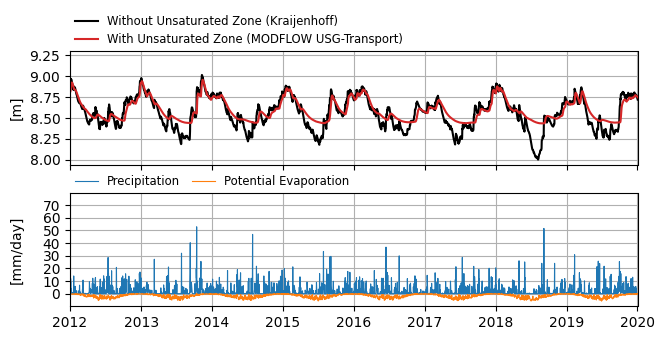

In [4]:
# load dataset
data = ps.load_dataset("vonk_2024")

prec = data["stresses"].loc[:, "prec [m/d]"].rename("prec").multiply(1e3)
evap = data["stresses"].loc[:, "evap [m/d]"].rename("evap").multiply(1e3)

# create synthetic series without unsaturated zone
pno = (prec - evap).rename("pno")
kml = ps.Model(pd.Series(np.zeros(len(pno)), index=pno.index))
kml.add_stressmodel(ps.StressModel(pno, ps.Kraijenhoff(), "rech", settings="evap"))
kml.set_parameter("rech_A", kraijenhoff_par[0], vary=False)
kml.set_parameter("rech_a", kraijenhoff_par[1], vary=False)
kml.set_parameter("rech_b", kraijenhoff_par[2], vary=False)
kml.set_parameter("constant_d", 8.5, vary=False)
sat_ref_h = kml.simulate(warmup=0).rename("Synthetic_Head_Saturated")

# synthetic series with unsaturated zone
uns_ref_h = data["heads_4mmevents"].loc[:, "SandyLoam_D85_REFERENCE"].rename("Synthetic_Head_Unsaturated")

# plot synthetic series
tmin = pd.Timestamp("2012-01-01")
tmax = pd.Timestamp("2020-01-01")

mosaic = [["head"], ["meteo"]]
f, axd = plt.subplot_mosaic(
    mosaic,
    figsize=(6.75, 3.5),
    sharex=True,
    constrained_layout=True,
)

axd["meteo"].plot(prec.index, prec, linewidth=0.8, color="C0", label="Precipitation")
axd["meteo"].plot(
    evap.index, -evap, linewidth=0.8, color="C1", label="Potential Evaporation"
)
axd["meteo"].legend(
    loc=(0, 1), ncol=2, frameon=False, columnspacing=1.0, fontsize="small"
)
axd["meteo"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
axd["meteo"].set_ylabel("[mm/day]")
axd["meteo"].grid(True)

axd["head"].plot(
    sat_ref_h.index,
    sat_ref_h.values,
    color="k",
    label="Without Unsaturated Zone (Kraijenhoff)",
)
axd["head"].plot(
    uns_ref_h.index,
    uns_ref_h.values,
    color="C3",
    label="With Unsaturated Zone (MODFLOW USG-Transport)",
)

axd["head"].legend(
    loc=(0, 1), ncol=1, frameon=False, columnspacing=1.0, fontsize="small"
)
axd["head"].set_ylabel("[m]")
axd["head"].grid(True)
axd["head"].set_xlim(tmin, tmax)
axd["head"].xaxis.set_major_locator(mpl.dates.YearLocator())
axd["head"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))

f.tight_layout(h_pad=0.05)
f.align_ylabels()

In the figure above, the two resulting synthetic series and the meteorological data
are shown. The head time series without the unsaturated zone varies between 8 and 9
meters, while the head time series with the unsaturated zone exhibits a smaller dynamic
range, varying between 8.4 and 9 meters. The synthetic series for the unsaturated zone
clearly demonstrates the nonlinear effects of evaporation reduction in the summer.


## Cross-correlogram

Cross-correlation is a measure of similarity of two time series as a function
of the shift of one series relative to the other. We can have only one input
time series and output time series. Because of that, the precipitation and
potential evaporation are combined into single input time series that
represents precipitation excess.

The cross-correlogram is the cross-correlation function visualized between the
input and output function against the number of lags. Below we show the
cross-correlation for one year (365 lags).

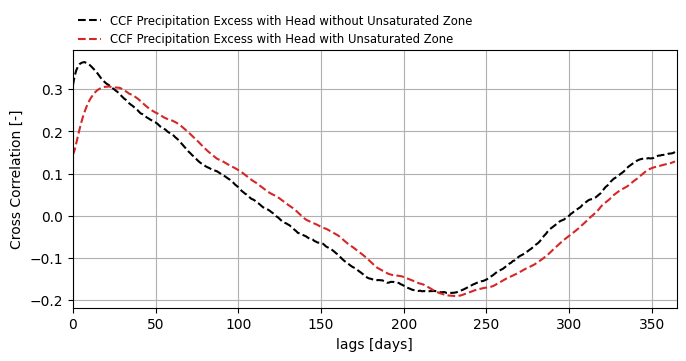

In [5]:
nlags = 365
ccf_sat = ppcc.ccf(sat_ref_h, pno, nlags=nlags)
ccf_uns = ppcc.ccf(uns_ref_h, pno, nlags=nlags)

f, ax = plt.subplots(figsize=(6.75, 3.5), constrained_layout=True)
ax.plot(
    ccf_sat.index,
    ccf_sat.values,
    color="k",
    linestyle="--",
    label="CCF Precipitation Excess with Head without Unsaturated Zone",
)
ax.plot(
    ccf_uns.index,
    ccf_uns.values,
    color="C3",
    linestyle="--",
    label="CCF Precipitation Excess with Head with Unsaturated Zone",
)
ax.grid(True)
ax.set_xlabel("lags [days]")
ax.set_ylabel("Cross Correlation [-]")
ax.legend(loc=(0, 1), frameon=False, ncol=1, fontsize="small")
ax.set_xlim(0, nlags);

In the cross-correlogram above we clearly see a relation between the precipitation
excess and both synthetic head series. In the head series without the
unsaturated zone the peak in cross correlation is larger and earlier. This is
to be expected since the unsaturated zone delays and dampens the effect of a
precipitation event. After ~125-150 days the cross-correlation becomes negative
which is probably related to seasonality in both the precipitation excess and
the head series.


### Prewhitening

While this cross-correlogram (up to a lag of about 225 days) already looks a bit like
a response function, this result is affected by autocorrelation in both the head
observations and precipitation excess. The autocorrelation in these series can
obfuscate the relationship between these variables. 

In order to obtain an estimate of the cross-correlation that is not affected by
autocorrelation we have to filter the time series. Removing the autocorrelation is
done by reducing one of the time series to white noise and applying that same filter to
the second time series. This process is called *prewhitening*. 

The filter used in this notebook is an autoregressive model of order $p$ where $p$ is
the number of lags (parameters) for the autoregressive model. The number of lags is
obtained iteratively. The autoregressive parameters of the filter are fitted using
least squares on the input time series, whereafter the same filter is applied on the
output (head) time series. 

Lets have a look at the cross-correlogram after prewhitening. We chose an arbitrary
amount of lags of 300 days for the autoregressive model. Generally, a large number for
the autoregressive parameter (e.g. >40) yields reasonable results, i.e. is able to
remove the autocorrelation in the time series.

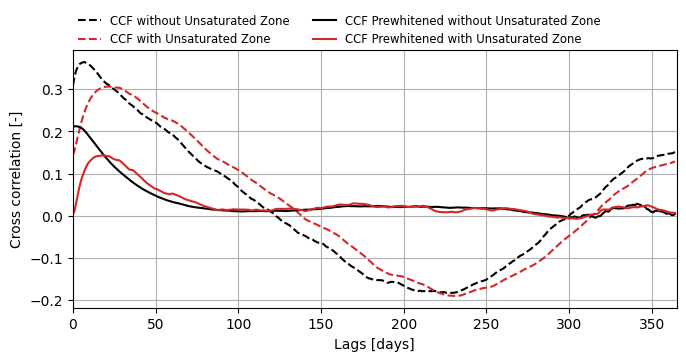

In [6]:
p = 300
pw_pno, pw_sat_ref_h = ppcc.prewhiten(pno, sat_ref_h, ar=p)
_, pw_uns_ref_h = ppcc.prewhiten(pno, uns_ref_h, ar=p)

pw_ccf_sat = ppcc.ccf(pw_sat_ref_h, pw_pno, nlags=nlags)
pw_ccf_uns = ppcc.ccf(pw_uns_ref_h, pw_pno, nlags=nlags)

f, ax = plt.subplots(figsize=(6.75, 3.5), constrained_layout=True)

ax.plot(
    ccf_sat.index,
    ccf_sat.values,
    color="k",
    linestyle="--",
    label="CCF without Unsaturated Zone",
)
ax.plot(
    ccf_uns.index,
    ccf_uns.values,
    color="C3",
    linestyle="--",
    label="CCF with Unsaturated Zone",
)
ax.plot(
    pw_ccf_sat.index,
    pw_ccf_sat.values,
    color="k",
    label="CCF Prewhitened without Unsaturated Zone",
)
ax.plot(
    pw_ccf_uns.index,
    pw_ccf_uns.values,
    color="C3",
    label="CCF Prewhitened with Unsaturated Zone",
)

ax.grid(True)
ax.set_xlabel("Lags [days]")
ax.set_ylabel("Cross correlation [-]")
ax.legend(loc=(0, 1), frameon=False, ncol=2, fontsize="small")
ax.set_xlim(0, nlags);

We again see a clear relation for the first 100 lags, after that the relation
hovers close to zero. Now that the cross-correlation is prewhitened, we can
obtain the impulse response as shown in the next section.

## Comparison with the true response

Now that we've computed the prewhitened cross-correlograms we want to see
whether how this relation compares to true response. To obtain the impulse
response function from the cross-correlogram, we have to multiply the
cross-correlation with the standard deviation of the prewhitened head series,
divided by the standard deviation of the prewhitened precipitation excess.
First, the we compare this impulse response to the true response for the system
without the unsaturated zone, after that for the (nonlinear) system with the
unsaturated zone.

### Without an unsaturated zone

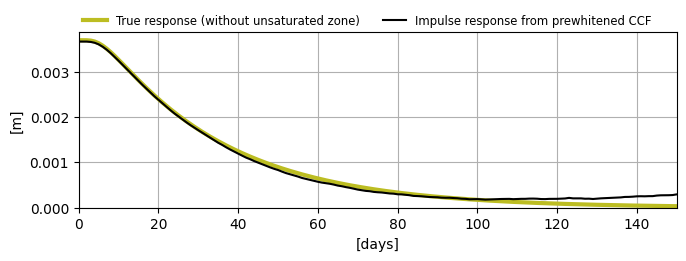

In [7]:
sf_sat = pw_sat_ref_h.std() / pw_pno.std()  # scaling factor to obtain impulse response

true_sat_response = ps.Kraijenhoff().block(
    kraijenhoff_par
)  # get true saturated response

# plot results
f, ax = plt.subplots(figsize=(6.75, 2.5), layout="constrained")
ax.plot(
    true_sat_response,
    label="True response (without unsaturated zone)",
    color="C8",
    linewidth=3.0,
)
ax.plot(
    pw_ccf_sat.index,
    pw_ccf_sat.values * sf_sat,
    color="k",
    label="Impulse response from prewhitened CCF",
)
ax.grid(True)
ax.set_ylabel("[m]")
ax.set_xlabel("[days]")
ax.set_xlim(0, 150)
ax.set_ylim(0.0)
ax.legend(loc=(0, 1), frameon=False, ncol=2, fontsize="small");

As shown in the figure above, the derived impulse response from the prewhitened
cross-correlation function matches closely with the true impulse response. The delay in
the first days, as well as the gradual decline to zero, overlap well. There is small
difference between the two impulse responses in the tail after about 100 days.

### With an unsaturated zone

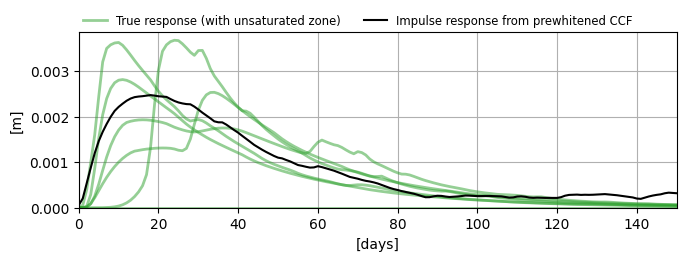

In [8]:
sf_uns = pw_uns_ref_h.std() / pw_pno.std()  # scaling factor to obtain impulse response

# obtain true responses
uns_other_h = data["heads_4mmevents"].iloc[:, 1:]
true_uns_responses = []
for c in uns_other_h.columns:
    head = uns_other_h.loc[:, c]
    diff = head - uns_ref_h
    tmin = pd.Timestamp(c.split("_")[-1])
    true_uns_responses.append(diff.loc[tmin:].divide(4).values)

# plot results
f, ax = plt.subplots(figsize=(6.75, 2.5), layout="constrained")
for response in true_uns_responses:
    ax.plot(
        response,
        color="C2",
        linewidth=2.0,
        alpha=0.5,
        label="True response (with unsaturated zone)",
    )
ax.plot(
    pw_ccf_uns.index,
    pw_ccf_uns.values * sf_sat,
    color="k",
    label="Impulse response from prewhitened CCF",
)
ax.grid(True)
ax.set_ylabel("[m]")
ax.set_xlabel("[days]")
ax.set_xlim(0, 150)
ax.set_ylim(0.0)
labels, handles = ax.get_legend_handles_labels()
ax.legend(
    labels[-2:], handles[-2:], loc=(0, 1), frameon=False, ncol=2, fontsize="small"
);

The true response of the synthetic aquifer with the unsaturated zone is difficult to
determine. That is why we calculate response of the head to 6 precipitation
events on random dates (for more information read up on Vonk et al (2024)). The
responses of the head to these 6 precipitation events events are shown as the
green lines in the figure above. The responses vary significantly, sometimes
they show multiple peaks and sometimes there is no response at all. The black
line showing the impulse response from the prewhitened cross-correlation
function looks like it represents an average response somewhere in the middle
of the green responses.

## Cross-correlogram applications

Response functions are a key part to time series modeling of head time series.
Identifying this response is a key step in the modeling process. One method to identify
this response is to compute the cross-correlogram between input and output time series.
We can use impulse response function from the cross-correlogram and and compare it to
the response functions in the Pastas library.

### Fitting the Gamma response function on the cross-correlogram

In this step the Gamma response function from Pastas is fitted to the impulse response
function from the cross-correlogram. The Gamma response has a flexible shape, and it
should be able to match the faster response of the linear system (no unsaturated zone)
as well as the delayed response of the nonlinear system (with unsaturated zone).

Let's try and fit the Gamma response. We use a smaller cutoff than usual (Pastas'
default is 0.999) so we don't add too much weight to fitting the tail of the impulse
response.

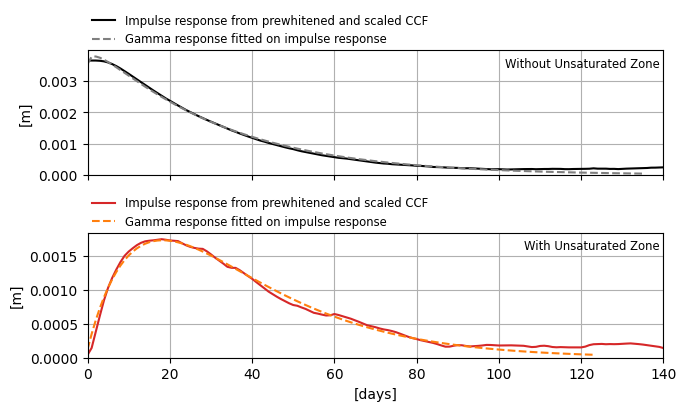

In [9]:
rfunc = ps.Gamma(cutoff=0.99)

par_sat = ppcc.fit_response(pw_ccf_sat, rfunc, scale_factor=sf_sat)
par_uns = ppcc.fit_response(pw_ccf_uns, rfunc, scale_factor=sf_uns)

response_sat = rfunc.block(par_sat)
response_uns = rfunc.block(par_uns)

f, axd = plt.subplot_mosaic(
    [["sat"], ["uns"]], figsize=(6.75, 4.0), sharex=True, constrained_layout=True
)
axd["sat"].plot(
    pw_ccf_sat * sf_sat,
    color="k",
    label="Impulse response from prewhitened and scaled CCF",
)
axd["uns"].plot(
    pw_ccf_uns * sf_uns,
    color="C3",
    label="Impulse response from prewhitened and scaled CCF",
)
axd["sat"].plot(
    response_sat,
    color="C7",
    linestyle="--",
    label="Gamma response fitted on impulse response",
)
axd["uns"].plot(
    response_uns,
    color="C1",
    linestyle="--",
    label="Gamma response fitted on impulse response",
)
axd["sat"].set_title("Without Unsaturated Zone ", loc="right", y=0.80, fontsize="small")
axd["uns"].set_title("With Unsaturated Zone ", loc="right", y=0.80, fontsize="small")
axd["sat"].grid(True)
axd["uns"].grid(True)
axd["sat"].legend(loc=(0, 1), frameon=False, fontsize="small")
axd["uns"].legend(loc=(0, 1), frameon=False, fontsize="small")
axd["sat"].set_ylim(bottom=0.0)
axd["uns"].set_ylim(bottom=0.0)
axd["sat"].set_ylabel("[m]")
axd["uns"].set_ylabel("[m]")
axd["uns"].set_xlim(0, 140)
axd["uns"].set_xlabel("[days]");

As we can see in the figure above the Gamma function seems to fit both response
functions very well. For the response without an unsaturated zone there is a
slight difference in the first few days of the impulse response. The response
according to the cross-correlation function is flat in those early days, which
the Gamma response cannot reproduce. The response of the system with
usnataturated zone also has some trouble in the first few days but after that
follows the shape and peak generally well.

### Fitting a linear time series model on the synthetic head series

Let's have a look at the estimated response function when time series models using the
Gamma response are build an fitted on the the synthetic series.

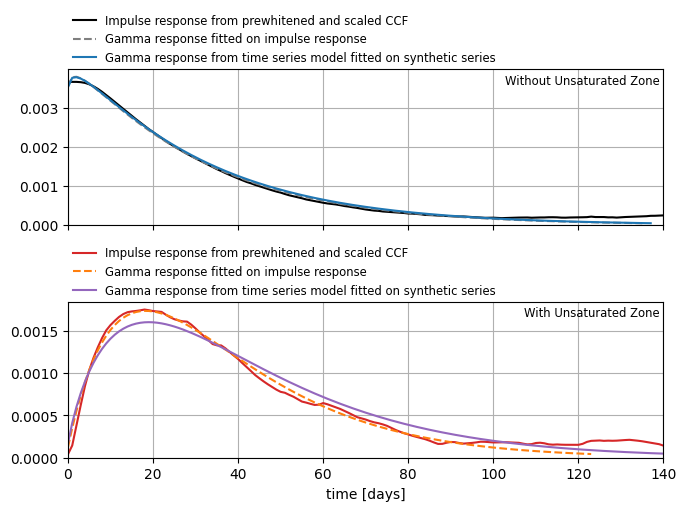

In [10]:
sm = ps.StressModel(pno, rfunc, "rech", settings="evap")

sat_model = ps.Model(sat_ref_h, name="Sat_Fit")
sat_model.add_stressmodel(sm)
sat_model.solve(report=False)

uns_model = ps.Model(uns_ref_h, name="Uns_Fit")
uns_model.add_stressmodel(sm)
uns_model.solve(report=False)

model_response_sat = rfunc.block(p=sat_model.parameters["optimal"].values[0:3])
model_response_uns = rfunc.block(p=uns_model.parameters["optimal"].values[0:3])

f, axd = plt.subplot_mosaic(
    [["sat"], ["uns"]], figsize=(6.75, 5.0), sharex=True, constrained_layout=True
)
axd["sat"].plot(
    pw_ccf_sat * sf_sat,
    color="k",
    label="Impulse response from prewhitened and scaled CCF",
)
axd["uns"].plot(
    pw_ccf_uns * sf_uns,
    color="C3",
    label="Impulse response from prewhitened and scaled CCF",
)
axd["sat"].plot(
    response_sat,
    color="C7",
    linestyle="--",
    label="Gamma response fitted on impulse response",
)
axd["uns"].plot(
    response_uns,
    color="C1",
    linestyle="--",
    label="Gamma response fitted on impulse response",
)
axd["sat"].plot(
    model_response_sat,
    color="C0",
    label="Gamma response from time series model fitted on synthetic series",
)
axd["uns"].plot(
    model_response_uns,
    color="C4",
    label="Gamma response from time series model fitted on synthetic series",
)
axd["sat"].set_title("Without Unsaturated Zone ", loc="right", y=0.85, fontsize="small")
axd["uns"].set_title("With Unsaturated Zone ", loc="right", y=0.85, fontsize="small")
axd["sat"].grid(True)
axd["uns"].grid(True)
axd["sat"].legend(loc=(0, 1), frameon=False, fontsize="small")
axd["uns"].legend(loc=(0, 1), frameon=False, fontsize="small")
axd["sat"].set_ylim(bottom=0.0)
axd["uns"].set_ylim(bottom=0.0)
axd["uns"].set_xlabel("time [days]")
axd["uns"].set_xlim(0, 140);

As we can see from the figure above, the response functions all look very similar.
The Gamma response estimated by the time series models and the one fitted on
the cross-correlogram match very closely, especially for the series without
unsaturated zone. For the series with unstaruted zone the gamma response has a
lower peak and a higher tail.

### Comparing time series models with cross-correlogram and fitted responses

Since we now have to time series models, we can compare them to a time series model with the paramters fitted on the cross-correlogram's impulse response. 

#### Without an unsaturated zone


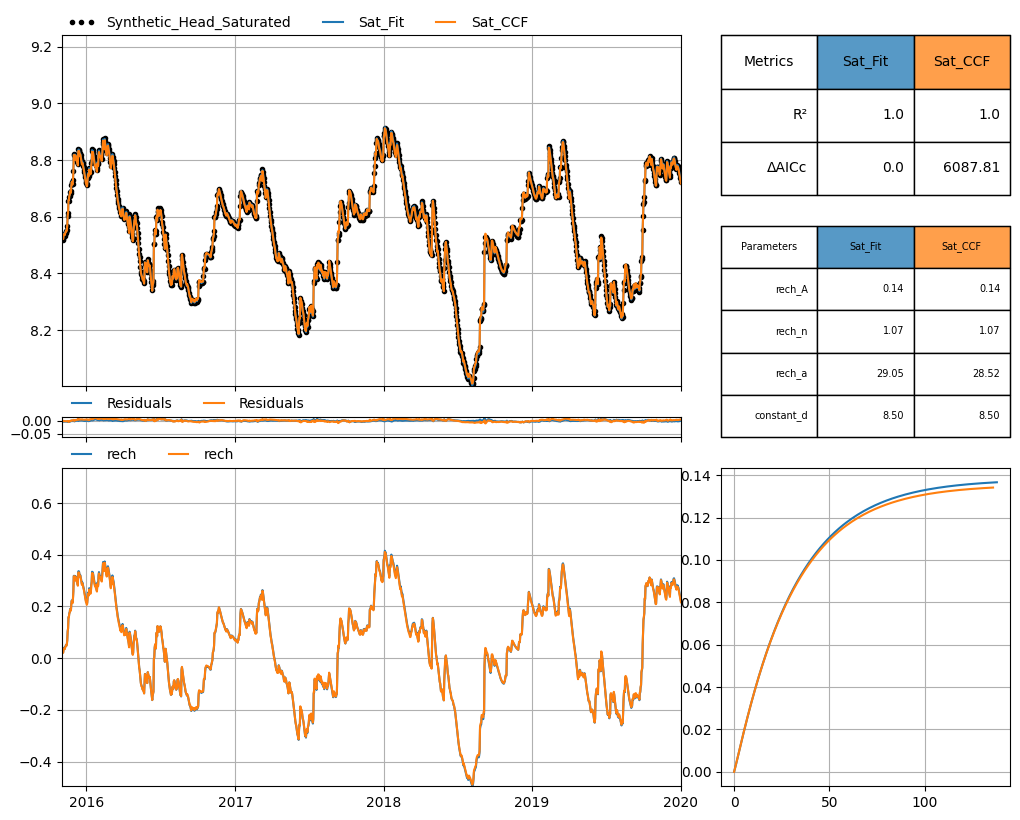

In [11]:
sat_model_ccf = sat_model.copy()
sat_model_ccf.name = "Sat_CCF"
sat_model_ccf.set_parameter("rech_A", optimal=par_sat[0])
sat_model_ccf.set_parameter("rech_n", optimal=par_sat[1])
sat_model_ccf.set_parameter("rech_a", optimal=par_sat[2])

axd = ps.plots.compare([sat_model, sat_model_ccf])
axd["sim"].set_xlim(tmin, tmax)
axd["sim"].xaxis.set_major_locator(mpl.dates.YearLocator())

#### With an unsaturated zone

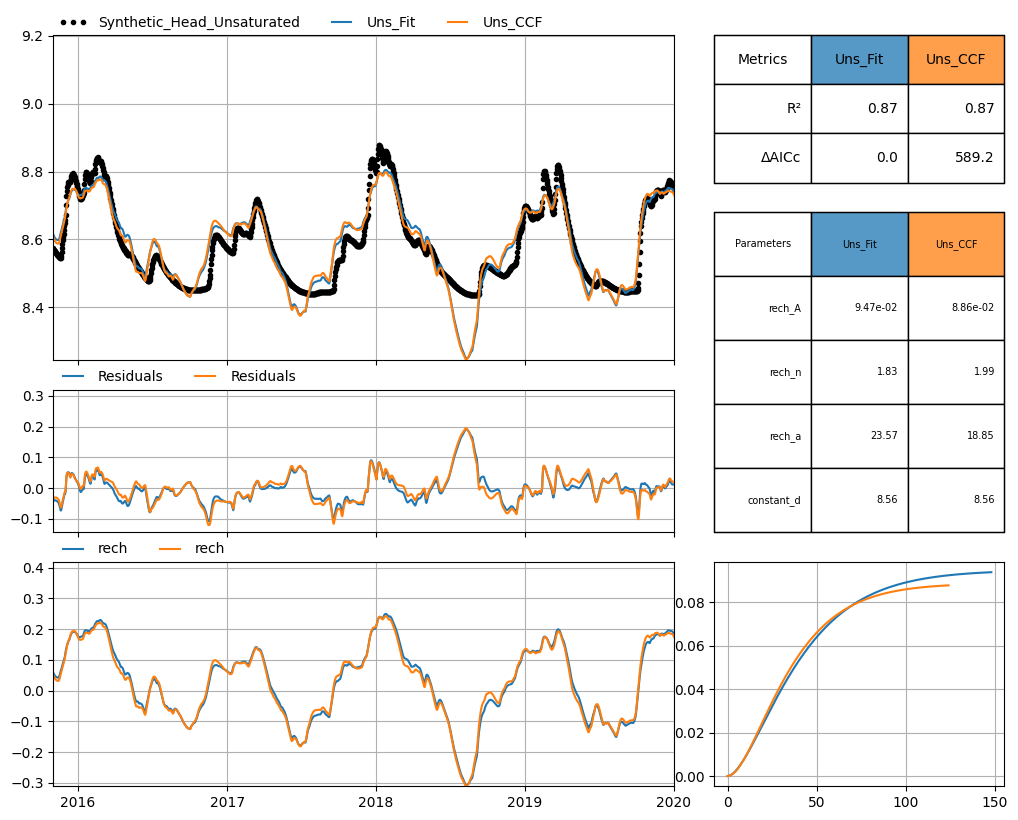

In [12]:
uns_model_ccf = uns_model.copy()
uns_model_ccf.name = "Uns_CCF"
uns_model_ccf.set_parameter("rech_A", optimal=par_uns[0])
uns_model_ccf.set_parameter("rech_n", optimal=par_uns[1])
uns_model_ccf.set_parameter("rech_a", optimal=par_uns[2])

axd = ps.plots.compare([uns_model, uns_model_ccf])
axd["sim"].set_xlim(tmin, tmax)
axd["sim"].xaxis.set_major_locator(mpl.dates.YearLocator())


For the situation without the unsaturated zone we see that both models have
almost a perfect. For the synthetic series with the unsaturated zone the fit of
both models is not perfect but still relatively high. For both synthetic series
the model with the response fitted on the CCF has a slightly lower fit which is
to be expected. Looking at the simulated head values for both responses the
results look very similar. This shows nicely that without a optimizing time
series model, and only an analysis of the cross-correlation and fitting a
response function on the cross-correlogram, a relatively good time series model
can be obtained. Relatively good because of the high fit, but for the series
with the unsaturated zone it would be better to use a nonlinear time series
model (Vonk et al. 2024).

## Concluding remarks

The cross-correlogram is a tool to obtain an estimate of the impulse response
of an output time series to an input time series. A Pastas response function
can be fitted on this prewhitened cross-correlation function to obtain an
initial guess of the parameters for a linear time series model.

The relation between the precipitation/evaporation stresses and the head is
often nonlinear. For systems that have a nonlinear response, the
cross-correlogram does not work as the response of the head to the input is
variable. In the synthetic nonlinear example, the cross-correlogram is able to
estimate some kind of average response, but that does not yield a model that is
able to accurately represent the behavior of the system. In that sense,
application of the cross-correlogram to identify the response of the head to
input time series (stresses) is limited when the system behaves in a nonlinear
fashion.

## References

- Box, G.E.P., Jenkins, G.M., Reinsel G.C., & Greta M. Ljung (2016). Time series
analysis: forecasting and control. Fifth edition. John Wiley & Sons, Inc. ISBN
978-1-118-67502-1.
- Vonk, M.A., Collenteur, R.A., Panday, S., Schaars, F., & Bakker, M. (2024). Time
Series Analysis of Nonlinear Head Dynamics Using Synthetic Data Generated with a
Variably Saturated Model. Groundwater. doi:
[10.1111/gwat.13403](https://doi.org/10.1111/gwat.13403).